In [1]:
# Setup Environment
import sys
sys.path.append("../")

import gym
from gym.spaces import Discrete
import numpy as np
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from source.agents.dqn_agent import DQNAgent
from source.utils import *
from tqdm import tqdm

test_linear_action_value passed!
test_tablular_action_value passed!


/Users/tonywy/micromamba/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


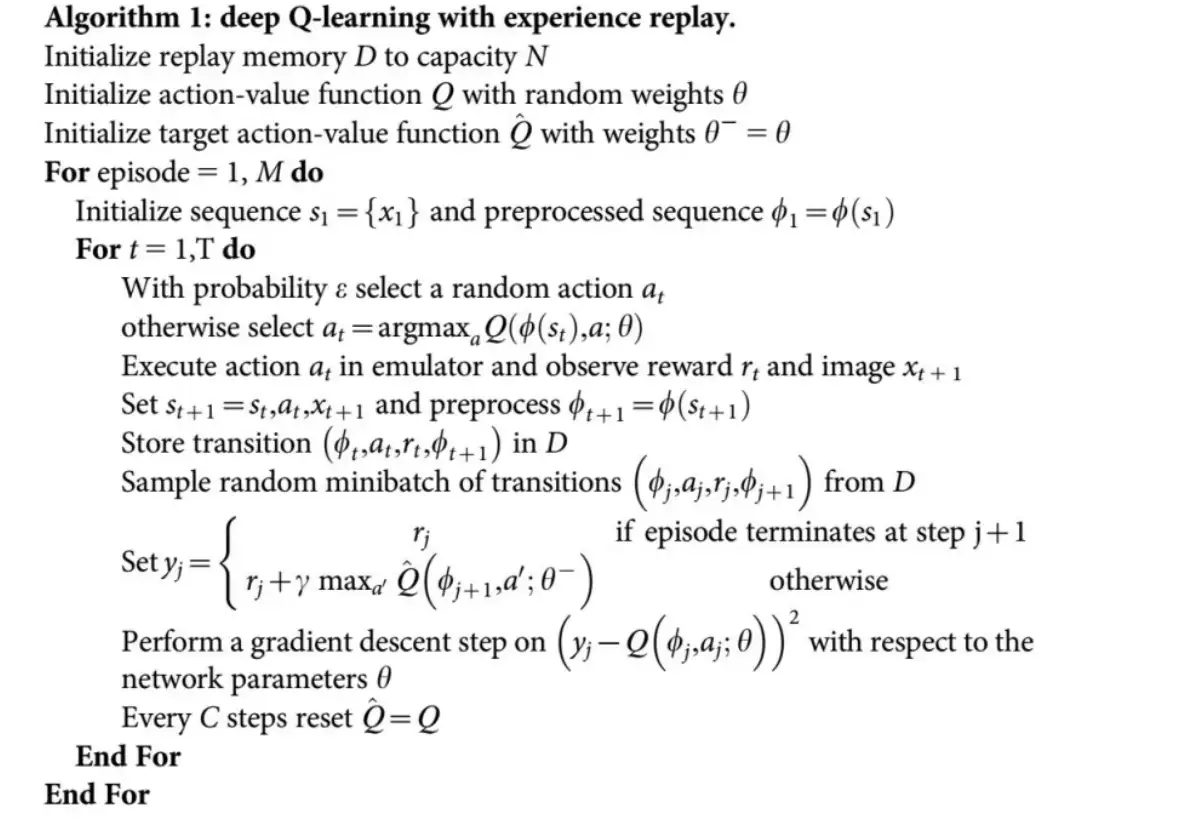

100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


step: 0, epsilon: 0.9, average_reward: -115.61750912841254, successful_episode: 0.02


100%|██████████| 100/100 [00:15<00:00,  6.56it/s]


step: 1, epsilon: 0.652301697309926, average_reward: -89.5500361633756, successful_episode: 0.01


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


step: 2, epsilon: 0.4727750047926781, average_reward: -62.94332930938804, successful_episode: 0.39


100%|██████████| 100/100 [00:31<00:00,  3.14it/s]


step: 3, epsilon: 0.34265770896885817, average_reward: -48.91832555252619, successful_episode: 0.4


100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


step: 4, epsilon: 0.24835133906301868, average_reward: -29.791180591314784, successful_episode: 0.74


100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


step: 5, epsilon: 0.18, average_reward: -11.467952939207185, successful_episode: 0.79


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


step: 6, epsilon: 0.1304603394619852, average_reward: 22.243993746765987, successful_episode: 0.98


100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


step: 7, epsilon: 0.09455500095853563, average_reward: 33.96740333183536, successful_episode: 0.92


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


step: 8, epsilon: 0.06853154179377163, average_reward: 51.25585368225128, successful_episode: 0.99


100%|██████████| 100/100 [00:54<00:00,  1.85it/s]


step: 9, epsilon: 0.05, average_reward: 64.07566384419444, successful_episode: 0.98

rewarding episodes: 64075.66384419441


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Success rate = 243.31504941358813


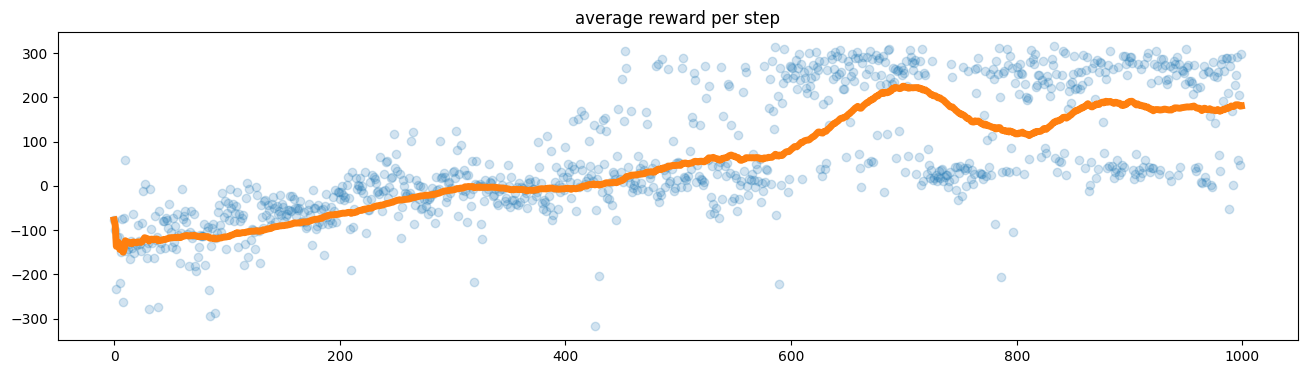

In [2]:
# Policy Eval
# Params
num_epoch = 10
num_episode = 100
video_path = "../video/sarsa_linear.mp4"
random_seed = 101

# Initialize
history = []
total_reward = 0
# set random seeds
rng = np.random.default_rng(random_seed)
np.random.seed(random_seed)
# epsilon decay
epsilon_schedule = create_decay_schedule(num_epoch)
lr_schedule = create_decay_schedule(num_epoch)

# Create Environment.
#env = gym.make('Taxi-v3')
# using render_mode=rgb_array so that video recording works
env = gym.make(
    "LunarLander-v2",
    render_mode='rgb_array'
)
env.np_random = rng

# Create Agent
agent = DQNAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    discount_rate=0.99,
    epsilon=None, # use epsilon_schedule
    learning_rate=1e-3,
    batch_size = 128,
    tau = 0.005,
)
# Start Learning
for i in range(num_epoch):
    hisotry = []
    success = 0
    for _ in tqdm(range(num_episode)):
        reward, steps = agent.play_episode(env,epsilon=epsilon_schedule[i])
        if reward > 0:
            success += 1
        history.append(reward)
        total_reward += reward
    #score = agent.update()
    print(
        f"step: {i}, epsilon: {agent._epsilon}, average_reward: {np.mean(history)}, successful_episode: {success / num_episode}")
print(f"\nrewarding episodes: {total_reward}")

# For off policy learning only: get greedy policy (no exploration)
#agent._policy = get_epsilon_greedy_policy_from_action_values(agent._Q.weight)
# Run Eval
success_rate = estimate_success_rate(agent, env, 100)
print(f"Success rate = {success_rate}")

# play last episode with video recording

plot_history(history)


In [8]:

agent2 = DQNAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    discount_rate=0.99,
    epsilon=None, # use epsilon_schedule
    learning_rate=1e-3,
    batch_size = 128,
    tau = 0.005,
)
reward, _ = agent.play_episode(env, learning=False, video_path=video_path, epsilon=0)
print(reward)
html=render_mp4(video_path)
HTML(html)


Moviepy - Building video ../video/sarsa_linear.mp4.
Moviepy - Writing video ../video/sarsa_linear.mp4



Moviepy - Done !
Moviepy - video ready ../video/sarsa_linear.mp4
283.7450221586605


# Summary

## Temporal Difference on policy learning 
Temporal difference combines Monte Carlo with dynamic programming.
```
V(s) = V(s) + learning_rate * (reward + discount_rate * V(s') - V(s))
```
The last part is also called TD-error:
```
td_error = (reward + discount_rate * V(s') - V(s))
```

### Sarsa
Sarsa requires `(state, action, reward, next_state, next_action)` to update action_values `_Q` and use that to create a epsilon-greedy policy `_policy`.

What makes it on-policy learning is that fact that `next_action` is both 
1. the action the agent is taking  -> behavior policy
2. the action the agent is using to update the action values `_Q` (policy evluation) -> target policy

The conflict is that 1 requires exploration to learn from unexplored environment. But 2 is affected by such exploration (because next action will not always be the optimal one, affecting the value of `_Q`). 


